<img src="figuras/logo.png" alt="logo" style="max-width: 450px;display: block">

<h1 style="text-align: center; font-size: 3rem;">Processamento e interpretação de
dados de campos potenciais  </h1>

<h1 style="text-align: center; font-size: 2.0rem;">Redução ao polo via transformada de Fourier (Reduction to the pole via Fourier transform)</h1>

## ℹ️ Sobre este tutorial

***Este código ilustra como calcular RTP usando transformada de Fourier, de anomalias de campo total produzidas por prismas retangulares homogêneos .***

## 🐍 Importe as bibliotecas necessárias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab

In [2]:
from codes import functions as func
from codes import plot_functions as plf
from codes import plot_function_pyvista as plv
from codes import prism

In [3]:
from codes.gravmag.models import rectangular_prism as rp

In [4]:
from codes.gravmag import filters, convolve, transforms

In [5]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 150

### Pontos onde calculamos os dados sintéticos

In [6]:
shape = (50, 50)

# Oeste, Leste, Sul, Norte
area = [-5000, 5000, -5000, 6000]

# espaçamento do grid
dx = (area[1] - area[0])/(shape[0]-1)
dy = (area[3] - area[2])/(shape[1]-1)

# coordenadas dos pontos de observação 
y = np.linspace(area[0], area[1], shape[0])
x = np.linspace(area[2], area[3], shape[1])

y, x = np.meshgrid(y, x)

y = np.ravel(y)
x = np.ravel(x)
z = np.zeros_like(y) -150

coordinates = np.vstack([y, x, z])

### Cria modelo formado por prismas

In [7]:
# prismas = [Oeste, Leste, Sul, Norte, Topo, Base]
prismas = np.array([[2000., 3000., -1500., -500.,10.,200.], 
                  [1600., 2600., -2500., -1500.,10.,200.], 
                  [-5000., 5000., 1500., 2500.,10.,200.],
                  [-3000., -2000., -4000., 1500.,10.,200.]])

### Magnetização de cada prisma a primeira, segunda e terceira colunas contêm a intensidade de magnetização (em A/m), inclinação e declinação (em graus) das fontes

In [8]:
inc, dec = 3, -45

magnetization = np.array([[4.4, inc, dec],
                          [4.3, inc, dec],
                          [1.1, inc, dec],
                          [1.2, inc, dec]])

### Magnetização usada para calcular RTP verdadeira,  a primeira, segunda e terceira colunas contêm a intensidade de magnetização (em A/m), inclinação e declinação (em graus) das fontes

In [9]:
magnetization_vertical = np.array([[4.4, 90, 0],
                                   [4.3, 90, 0],
                                   [1.1, 90, 0],
                                   [1.2, 90, 0]])

### Campo principal 

In [10]:
# reference point
yc, xc = 0, 1000

# inclination (degrees)
I0 = 6 - 1e-4*(x-xc) + 3e-4*(y-yc) + 1e-8*(x-xc)*(x-xc) + 1e-8*(y-yc)*(y-yc)

# declination (degrees)
D0 = 45 + 6e-5*(x-xc) + 1e-4*(y-yc) + 3e-9*(x-xc)*(x-xc) + 4e-9*(y-yc)*(y-yc)

# intensity (nT)
F0 = 23400 + 1e-4*(x-xc) + 1e-4*(y-yc) + 0*(x-xc)*(x-xc) + 0*(y-yc)*(y-yc)

# Cartesian components of the main field
cosI0 = np.cos(np.deg2rad(I0))
sinI0 = np.sin(np.deg2rad(I0))
cosD0 = np.cos(np.deg2rad(D0))
sinD0 = np.sin(np.deg2rad(D0))
Fx = F0*cosI0*cosD0
Fy = F0*cosI0*sinD0
Fz = F0*sinI0

### Campo residual sintético

In [11]:
# Compute the magnetic field components
bx = prism.mag(coordinates=coordinates, prisms=prismas, magnetization=magnetization, field='b_x')
by = prism.mag(coordinates=coordinates, prisms=prismas, magnetization=magnetization, field='b_y')
bz = prism.mag(coordinates=coordinates, prisms=prismas, magnetization=magnetization, field='b_z')

# Add a noise to the synthetic data
bx += np.random.normal(loc=0, scale=5, size=bx.size)
by += np.random.normal(loc=0, scale=5, size=by.size)
bz += np.random.normal(loc=0, scale=5, size=bz.size)

# Compute the total-field anomaly
tfa = np.sqrt((Fx+bx)**2 + (Fy+by)**2 + (Fz+bz)**2) - F0

# Compute the approximated total-field anomaly
mean_I0 = np.mean(I0)
mean_D0 = np.mean(D0)
cos_mean_I0 = np.cos(np.deg2rad(mean_I0))
sin_mean_I0 = np.sin(np.deg2rad(mean_I0))
cos_mean_D0 = np.cos(np.deg2rad(mean_D0))
sin_mean_D0 = np.sin(np.deg2rad(mean_D0))
Fx_hat = cos_mean_I0*cos_mean_D0
Fy_hat = cos_mean_I0*sin_mean_D0
Fz_hat = sin_mean_I0

approx_tfa = Fx_hat*bx + Fy_hat*by + Fz_hat*bz
diff_tfa = approx_tfa - tfa

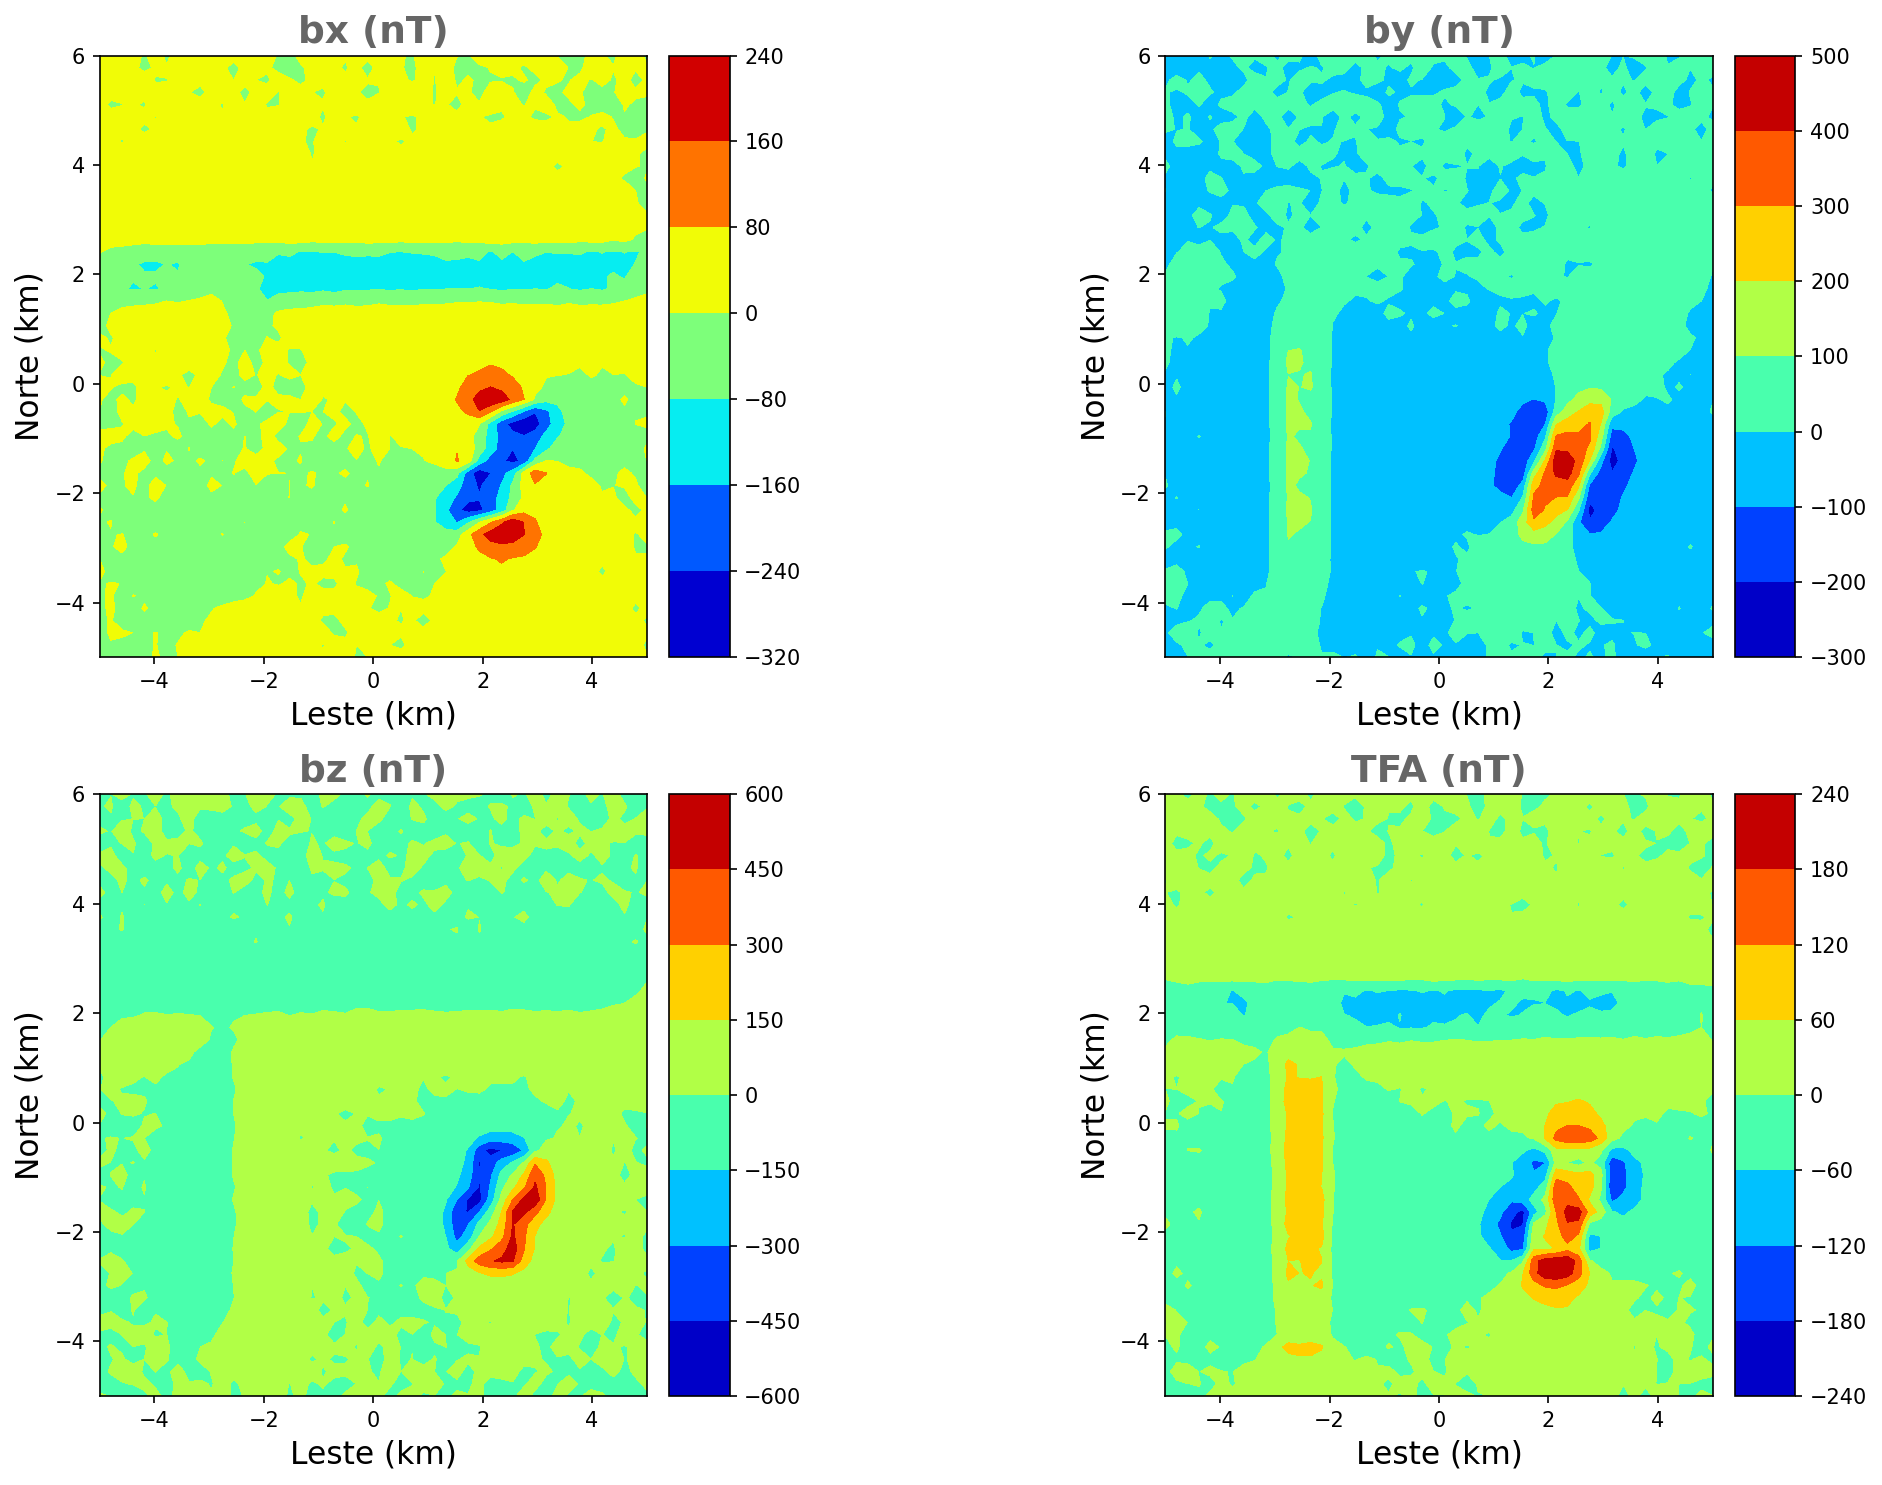

In [12]:
fields = [bx, by, bz, tfa]
windows = [1, 2, 3, 4]
titles = ['bx (nT)', 'by (nT)', 'bz (nT)', 'TFA (nT)']

plt.figure(figsize=(15,10))

for w, window in enumerate(windows):

    plt.subplot(2,2,window)
    plt.title(titles[w], fontsize=18,weight='bold', alpha=.6)
    plt.axis('scaled')
    plt.contourf(y.reshape(shape)*0.001, 
                 x.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='jet')
    plt.colorbar(shrink=1.0, pad=0.02, aspect=10)
#     plf.model_boundaries_2(prismas, m2km=True,linewidth = 2)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('Leste (km)', fontsize=15)
    plt.ylabel('Norte (km)', fontsize=15)

plt.tight_layout()
plt.savefig('figuras/notebook-3/TFA.png',dpi = 500, bbox_inches = 'tight')
plt.show()

###  RTP sintético

In [13]:
# Calcula uma anomalia RTP "verdadeira"
rtp_anomaly = prism.mag(coordinates=coordinates,
                        prisms=prismas,
                        magnetization=magnetization_vertical,
                        field='b_z')

rtp_anomaly += np.random.normal(loc=0, scale=5, size=rtp_anomaly.size)

### Plot da TFA verdadeira e TFA reduzido ao polo

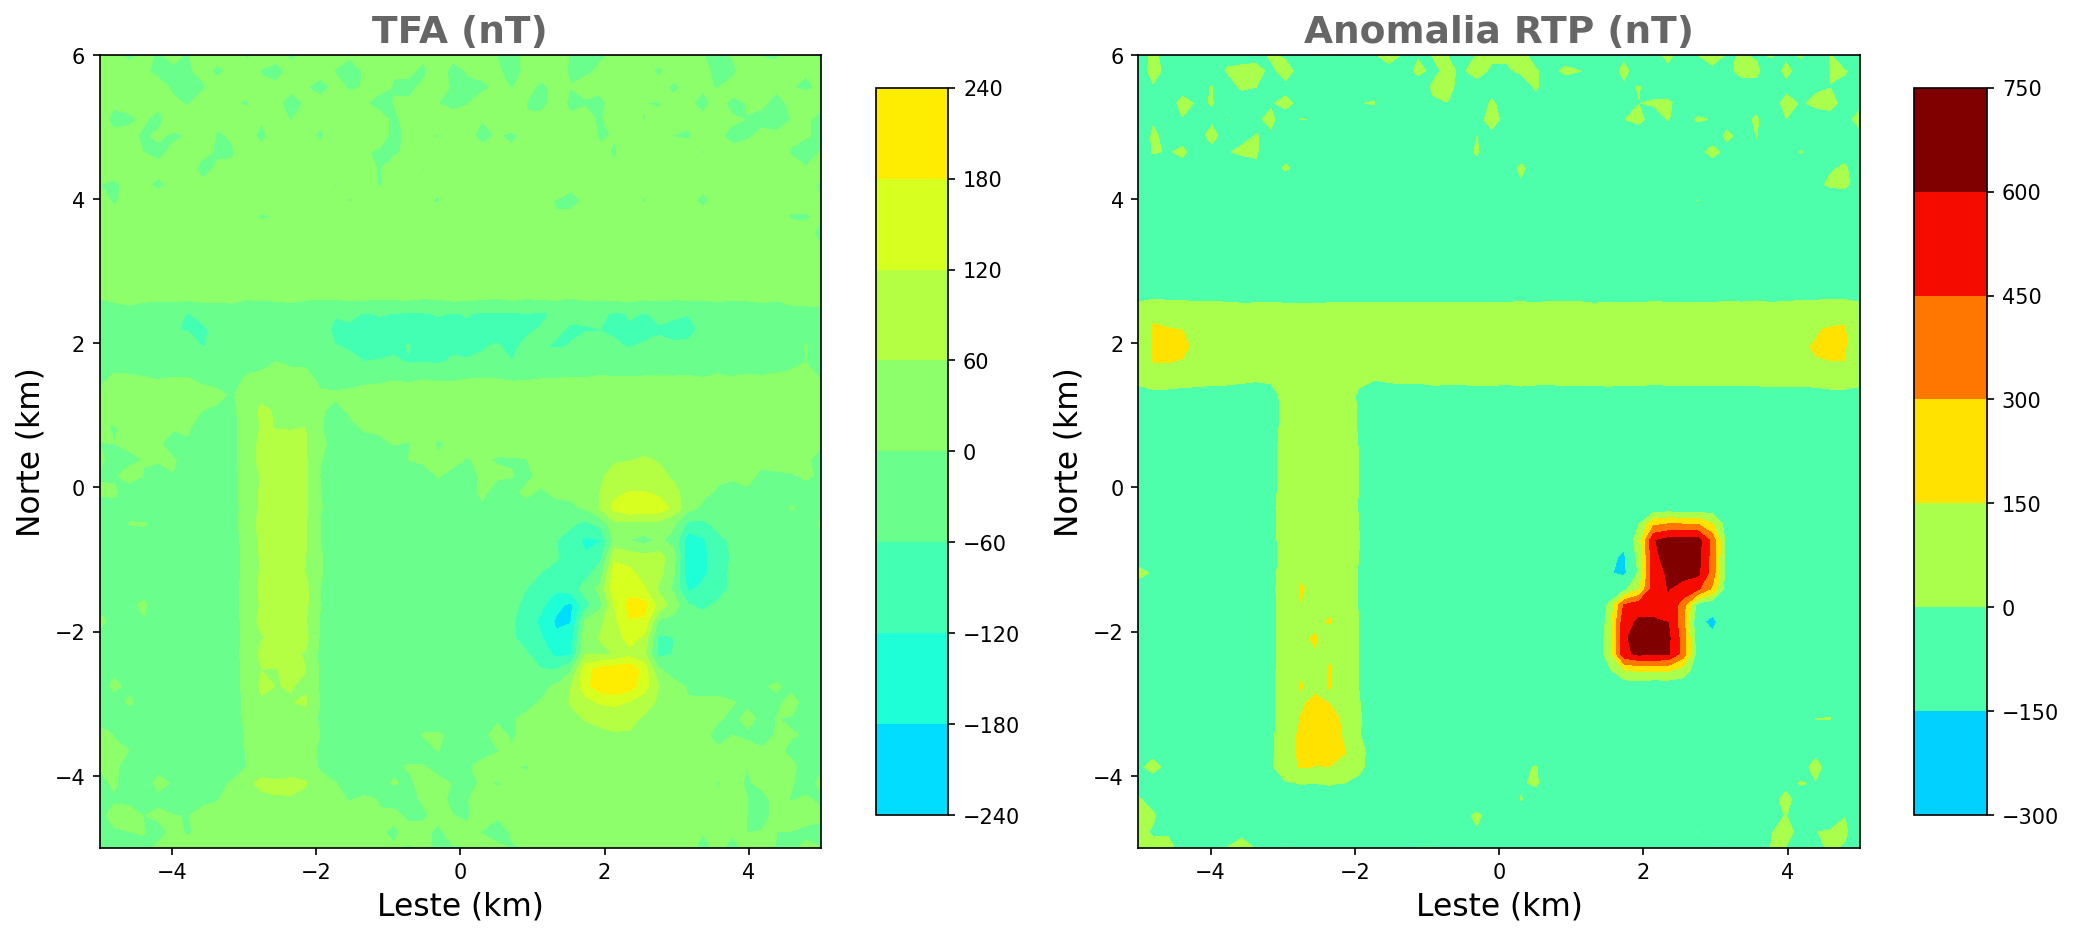

In [14]:
fields = [tfa, rtp_anomaly]
windows = [1, 2]
titles = ['TFA (nT)', 'Anomalia RTP (nT)',]
ranges = np.max(np.abs([tfa, rtp_anomaly]))


plt.figure(figsize=(14,10))

for w, window in enumerate(windows):

    plt.subplot(1,2,window)
    plt.title(titles[w], fontsize=18,weight='bold', alpha=.6)
    plt.axis('scaled')
    plt.contourf(y.reshape(shape)*0.001, 
                 x.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='jet',vmin = -ranges, vmax = ranges)
    
    plt.colorbar(shrink=0.5, pad=0.06, aspect=10)
#     plf.model_boundaries_2(prismas, m2km=True,linewidth = 2)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('Leste (km)', fontsize=15)
    plt.ylabel('Norte (km)', fontsize=15)

plt.tight_layout()
plt.savefig('figuras/notebook-3/TFA_TFA-RTP.png',dpi = 500, bbox_inches = 'tight')
plt.show()

## RTP via transformada de Fourier

In [15]:
# Transformada de Fourier 2D do dados de TFA com padding
F_tfa = transforms.DFT(tfa.reshape(shape), pad_mode='linear_ramp')

# Calcula o numero de ondas associado ao grid 
kx, ky, kz = transforms.wavenumbers(F_tfa.shape, dx, dy)

# Calcula o filtro RTP no dominio de Fourier
rtp_filter = filters.rtp(kx, ky, kz, mean_I0, mean_D0, inc, dec)

# Calcula a anomalia RTP no dominio de Fourier
FT_rtp = convolve.compute(FT_data=F_tfa, filters=[rtp_filter])

# Calcula a tranformada de Fourier inversa 2D
estimated_rtp_anomaly = transforms.IDFT(FT_rtp, unpad=True, grid=False)

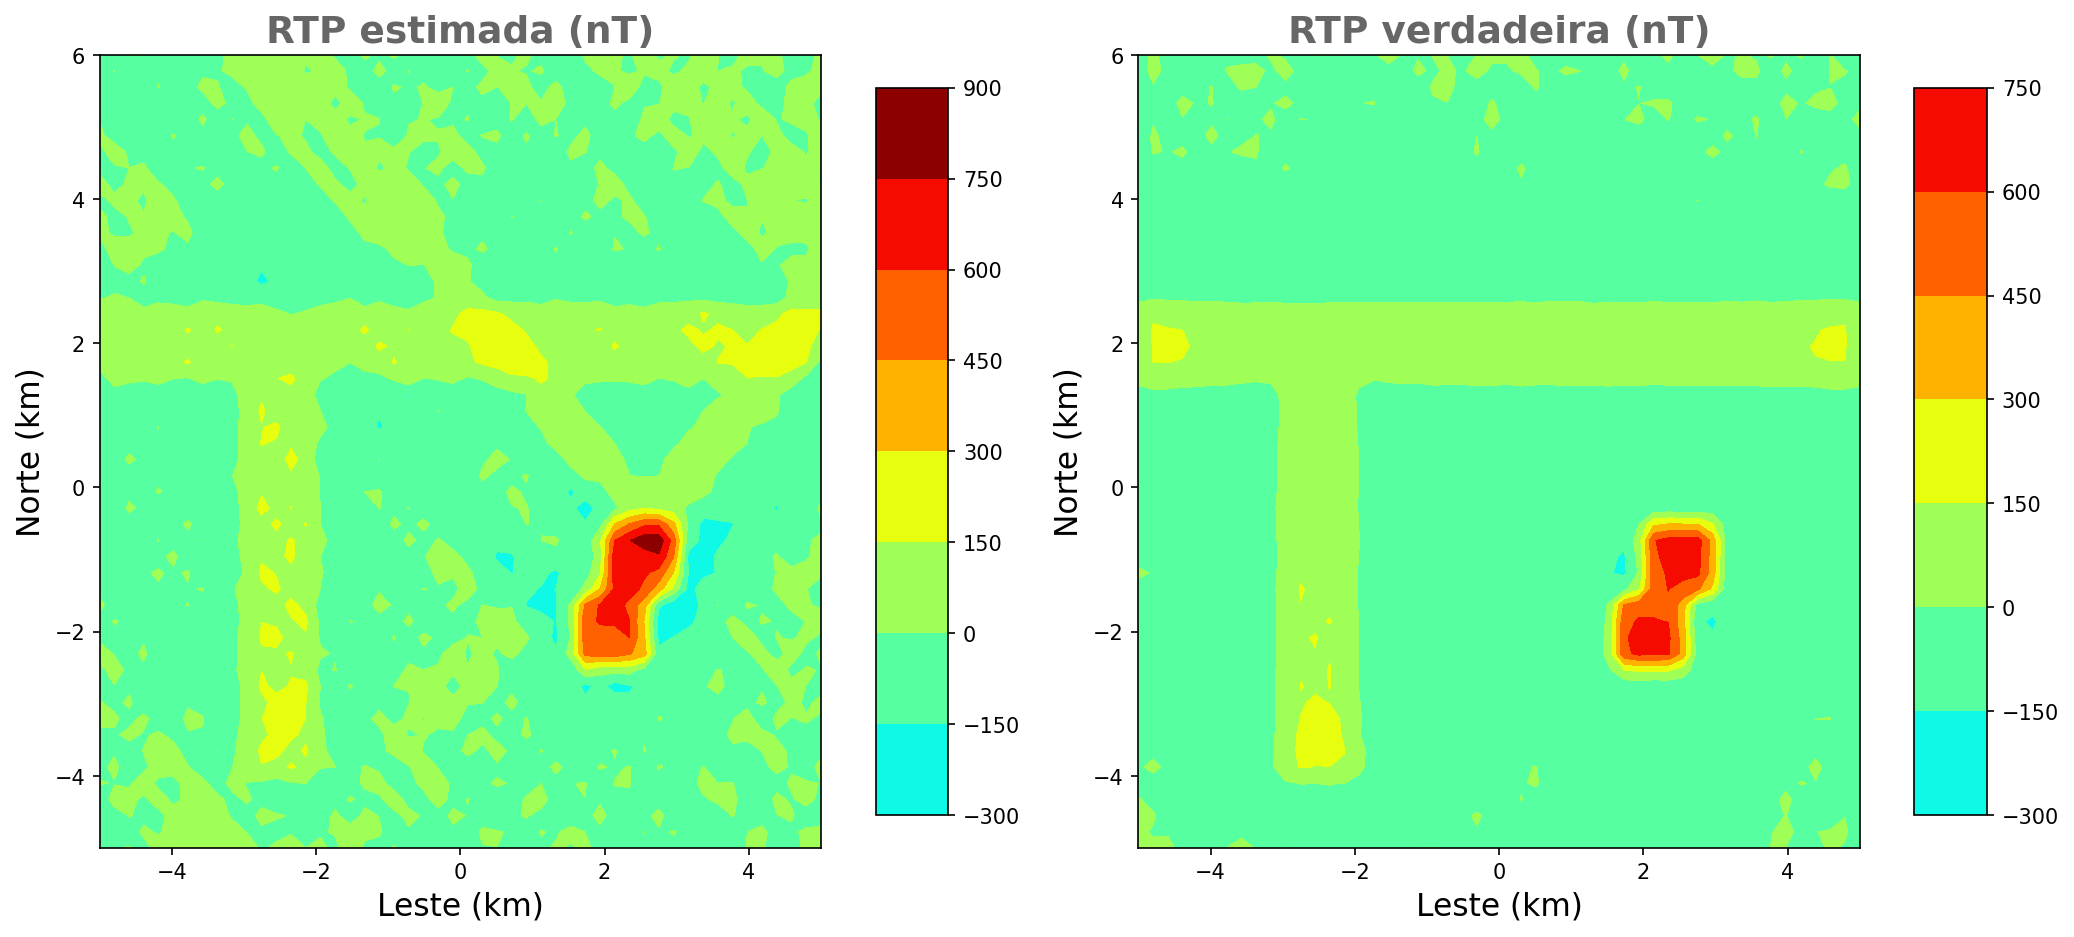

In [16]:
fields = [estimated_rtp_anomaly, rtp_anomaly]
windows = [1, 2]
titles = ['RTP estimada (nT)', 'RTP verdadeira (nT)' ]
ranges = np.max(np.abs([estimated_rtp_anomaly, rtp_anomaly]))

plt.figure(figsize=(14,10))

for w, window in enumerate(windows):

    plt.subplot(1,2,window)
    plt.title(titles[w], fontsize=18,weight='bold', alpha=.6)
    plt.axis('scaled')
    plt.contourf(y.reshape(shape)*0.001, 
                 x.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='jet',vmin = -ranges, vmax = ranges)
    
    plt.colorbar(shrink=0.5, pad=0.06, aspect=10)
#     plf.model_boundaries_2(prismas, m2km=True,linewidth = 2)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('Leste (km)', fontsize=15)
    plt.ylabel('Norte (km)', fontsize=15)

plt.tight_layout()
plt.savefig('figuras/notebook-3/TFA-RTP_estimado.png',dpi = 500, bbox_inches = 'tight')
plt.show()

## Ajustando uma distribuição normal de dados 1D

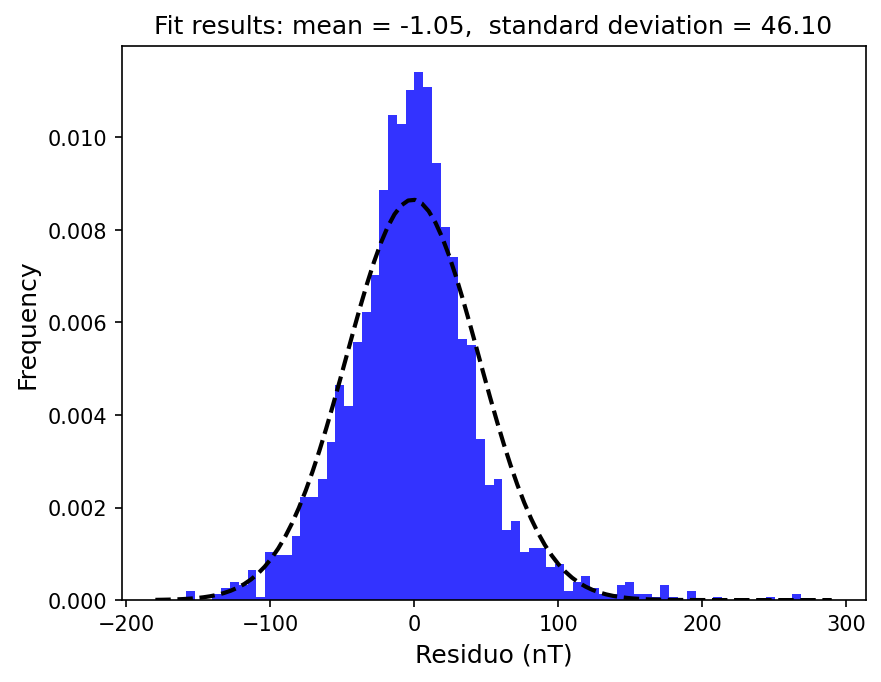

In [26]:
residuo = estimated_rtp_anomaly - rtp_anomaly
# Fit a normal distribution to the data:
mu, std = norm.fit(residuo)

# Plot the histogram.
# plt.figure(figsize=(8,4))
weights = np.ones_like(residuo) / len(residuo)
plt.hist(residuo,weights=weights, bins=70, density=True, alpha=0.8, color='blue')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k--', linewidth=2)
title = "Fit results: mean = %.2f,  standard deviation = %.2f" % (mu, std)
plt.title(title)

plt.xlabel('Residuo (nT)' , fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.savefig('figuras/notebook-3/normal_distribution.png',dpi = 500, bbox_inches = 'tight')
plt.show()